In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [ ]:
def get_nconts(pdb_txt, chain="A", distance_cutoff=6.0, plddt_cutoff=0): 
    """
    Calculates number of contaict in a protein.

    """

    # Get all C-alpha atoms with specific pLDDT cutoff
    ca_data, plddt = [],[]
    for line in pdb_txt.splitlines():
        col = line.split()
        if col[0] == 'ATOM'and col[4] == chain:
            plddt.append(float(col[10]))
        if (col[0] == 'ATOM' and col[2] == 'CB' and float(col[10]) > plddt_cutoff and col[4] == chain) :
            ca_data.append([
            int(col[5]), # residue index 
            np.array(list(map(float, col[6:9]))), #xyz
            float(col[10]) #pLDDT   
            ])
    if len(ca_data) == 0:
        mean_plddt = np.mean(np.array(plddt))
        return(1, round(mean_plddt * 0.01, 2))
    else:    
        coords = np.array([item[1] for item in ca_data])  # Extract coordinates
        CA_pLDDT = np.mean(np.array([item[2] for item in ca_data]))
        n_atoms = len(coords)
        pairs_data = np.zeros((0, 5))

        distances_matrix = np.linalg.norm(coords[:, None] - coords, axis=2)
        row = 0
        for i in range(n_atoms):
            for j in range(i + 4, n_atoms): # do not calc dist between atoms i, ... i+4
                if distances_matrix[i, j] < distance_cutoff:
                    #pairs_data = np.append(pairs_data, [[row, ca_data[i][0], ca_data[j][0], np.mean([ca_data[i][2], ca_data[j][2]]), distances_matrix[i, j]]], axis=0)
                    row += 1
        return(row, round(CA_pLDDT * 0.01, 2), distances_matrix)





In [ ]:
pdbs = []
for pdb in os.listdir('pdb'):
    f = open('pdb/' +pdb)
    text = f.read()
    pdbs.append(text)

In [ ]:
np.flatnonzero(matrix < 5)


In [ ]:
n, plddt, matrix = get_nconts(pdbs[1], 'A', 6, 0)
plt.matshow(matrix)
#plt.xticks(())  # remove x tick marks
#plt.yticks(())  # remove y tick marks
plt.show()


In [ ]:
from threading import Thread
import time
def test(b):
    a=5
    time.sleep(1)
    a += 1 + b
    return(a)

In [ ]:
def countdown(thread, count):
    while count > 0:
        count -= 1


In [1]:
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns
from matplotlib import colors
from matplotlib.lines import Line2D


In [39]:
%%bash 

grep -v "#" progress3.log  | awk -F"\t" '{print $11}' | fold -w1 | sort | uniq -c

11654479 C
6657424 E
 262821 F
1568513 G
19192718 H
  37260 I
 244239 P
   2287 f
   3152 g
      2 s


In [40]:
%%bash 

grep -v "#" 5yiw_3_progress.log | awk  -F"\t" '{print $13}' | tail -n +30 |  fold -w1 | sort | uniq -c

1274846 C
   4662 E
  33818 F
  38130 G
2110058 H
    432 I
  22770 P
    864 f
   1107 g


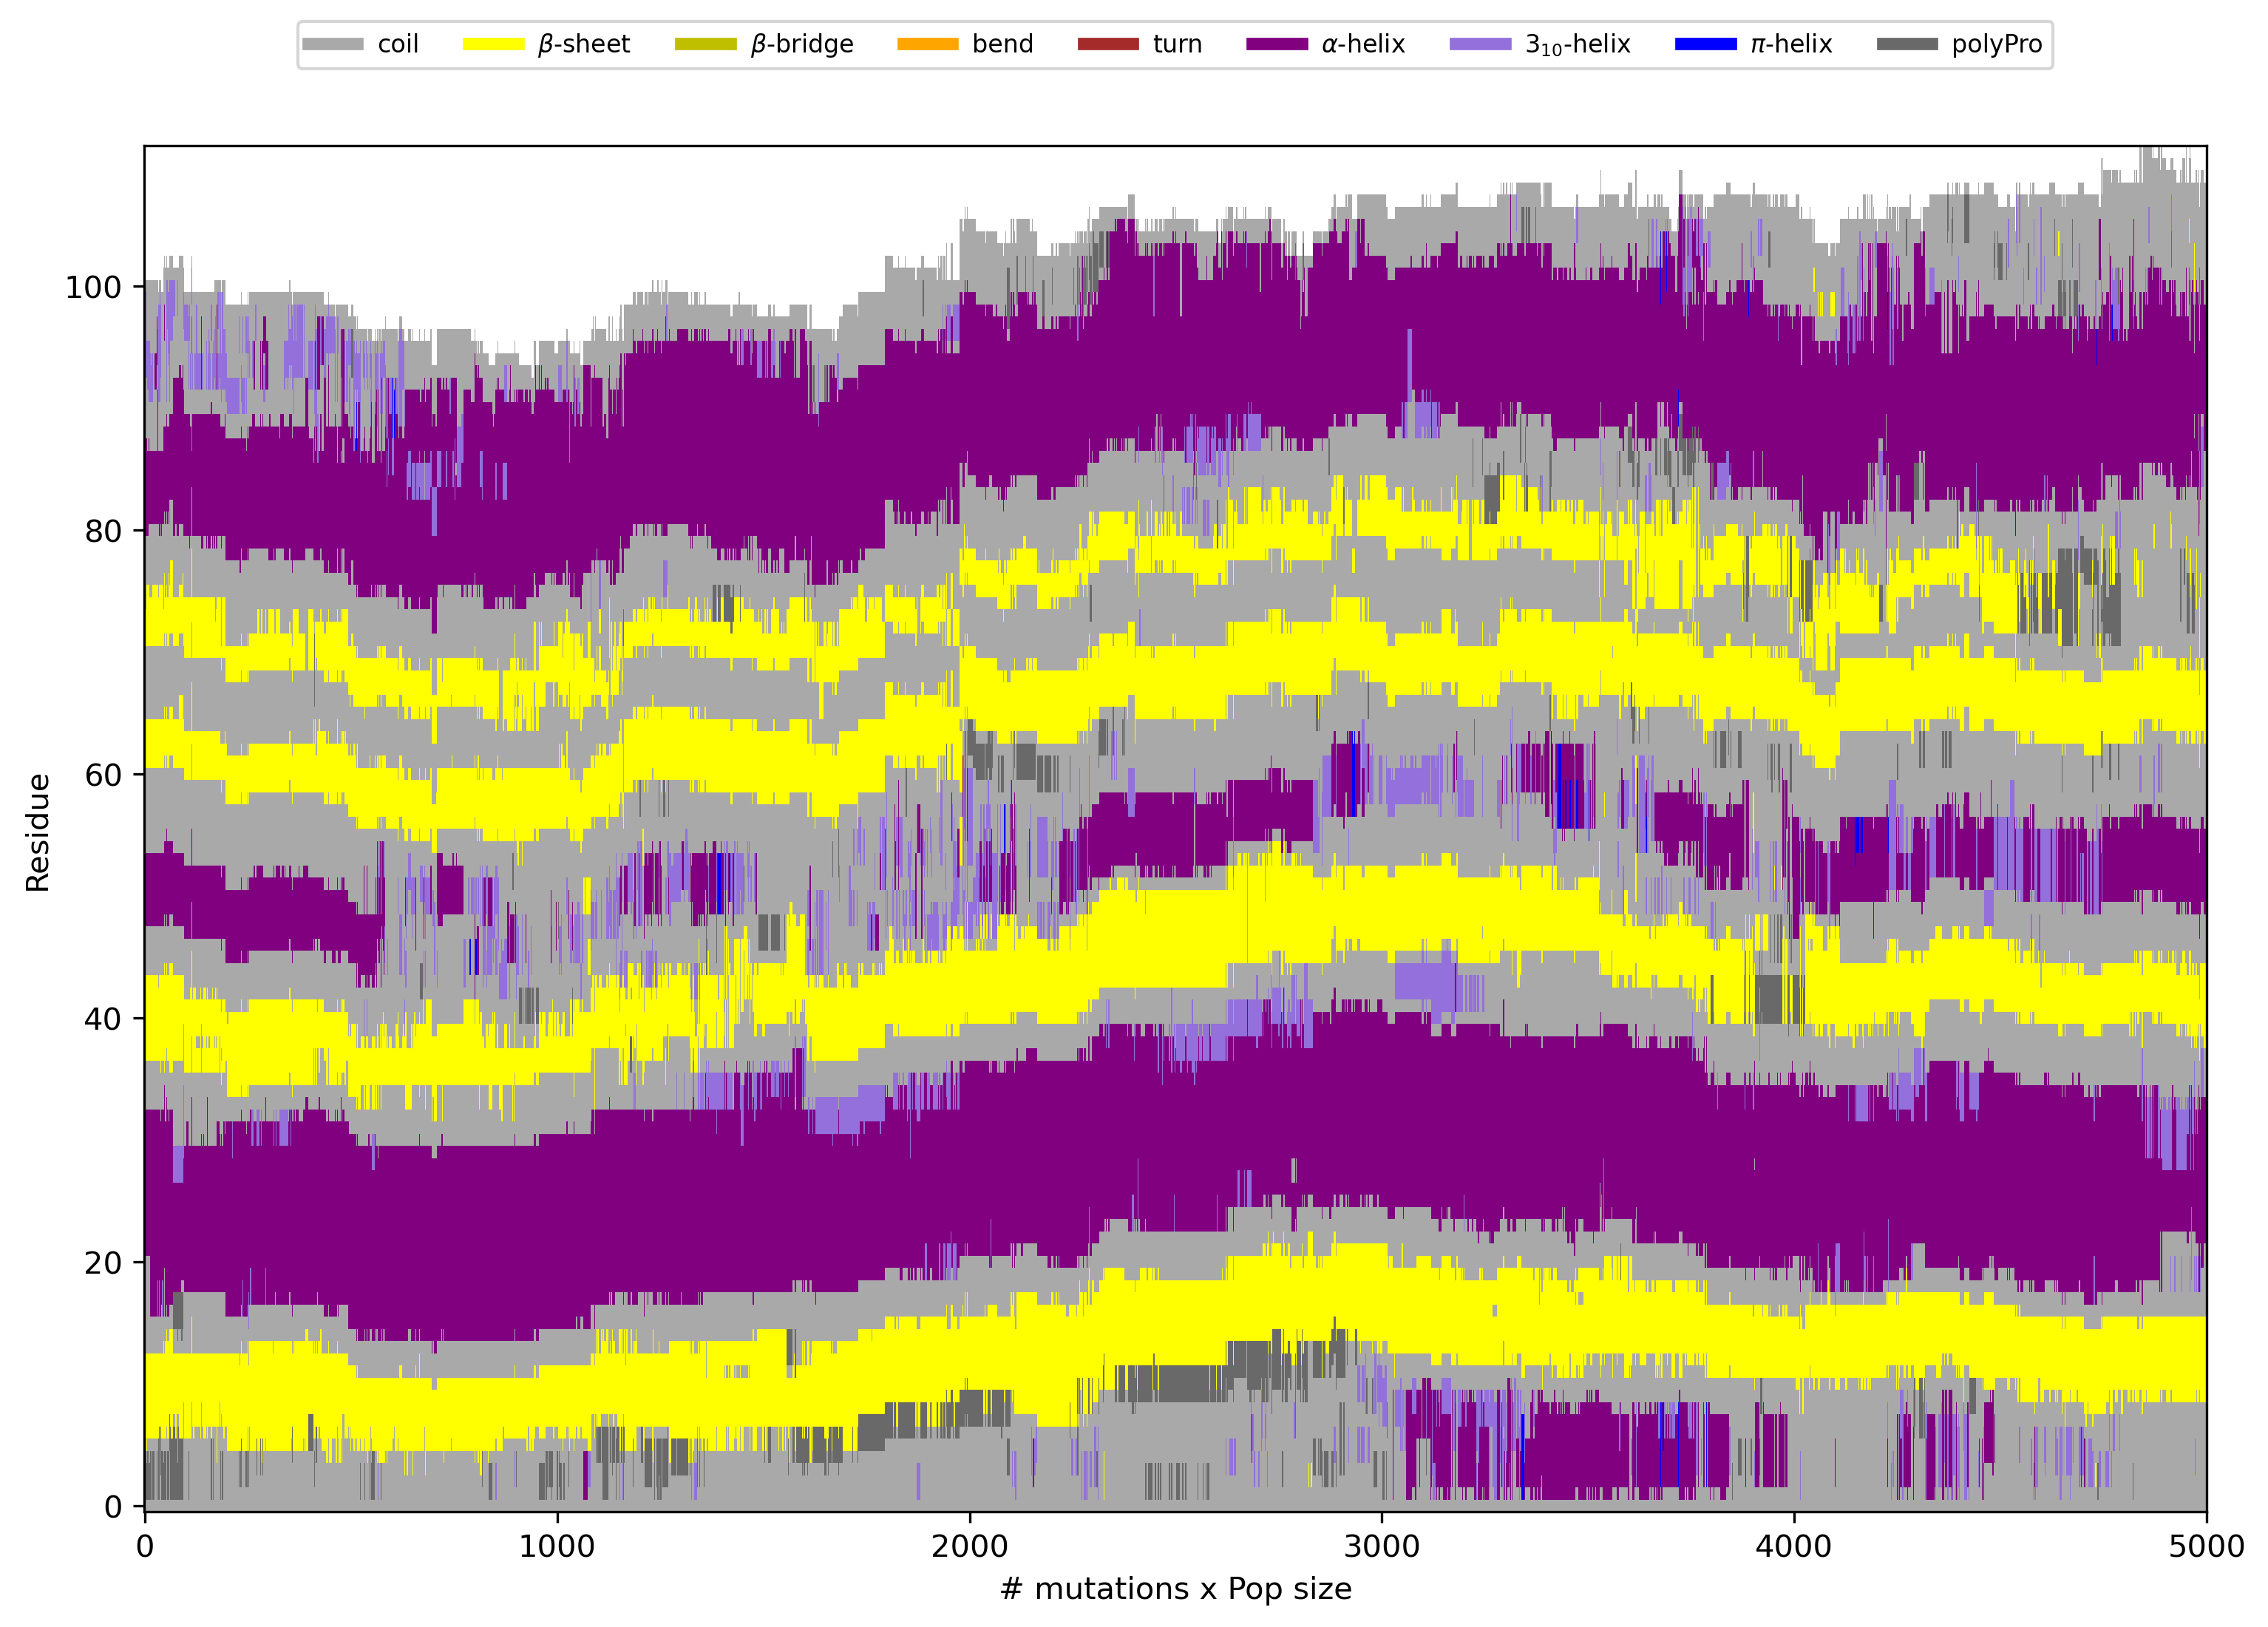

In [167]:
#log = pd.read_csv('5yiw_3_progress.log', sep='\t', comment='#')
log = pd.read_csv('progress.log', sep='\t', comment='#')
#log = pd.read_csv('progress3.log', sep='\t', comment='#')


bestlog = log.groupby('gndx').head(1)

max_seq_len = int(max(bestlog.seq_len))
bestlog_len = len(bestlog)
dpi = 300

sse = np.empty((bestlog_len, max_seq_len), dtype='U1')

i=0
for ss in bestlog.ss:
    sse[i] = list(ss + "X"*(max_seq_len-len(ss)))
    i+=1

def sse_to_num(sse):
    num = np.empty(sse.shape, dtype=int)
    num[sse == 'F'] = 0
    num[sse == 'f'] = 0
    num[sse == 'g'] = 0
    num[sse == 's'] = 0
    num[sse == 'C'] = 0    # r"coil": "grey",  #r"coil": "grey",
    num[sse == 'E'] = 1    # r"$\beta$-sheet": "yellow",  
    num[sse == 'B'] = 2    # r"$\beta$-bridge": "orange",  
    num[sse == 'S'] = 3    # r"bend": "cyan",  
    num[sse == 'T'] = 4    # r"turn": "brown",  
    num[sse == 'H'] = 5    # r"$\alpha$-helix": "purple",  
    num[sse == 'G'] = 6    # r"$3_{10}$-helix": "pink",  
    num[sse == 'I'] = 7    # r"$\pi$-helix": "blue",  
    num[sse == 'P'] = 8    # r"polyPro": "black",  
    num[sse == 'X'] = 9   # r"X": "white"  
    return num


sse_digit = sse_to_num(sse)


color_assign = {
    r"coil": "darkgrey",
    r"$\beta$-sheet": "yellow",
    r"$\beta$-bridge": "y",
    r"bend": "orange",
    r"turn": "brown",
    r"$\alpha$-helix": "purple",
    r"$3_{10}$-helix": "mediumpurple",
    r"$\pi$-helix": "blue",
    r"polyPro": "dimgrey",
    r"": "white"
    }


cmap = colors.ListedColormap(color_assign.values())

ticks = np.arange(0, len(bestlog)+1, 1000)


plt.figure(figsize=(12, 8), dpi=dpi)
plt.imshow(sse_digit.T, origin='lower', cmap=cmap,  interpolation='nearest', aspect='auto')
plt.xticks(ticks, ticks.astype(int))
plt.xlabel("# mutations x Pop size")
plt.ylabel("Residue")

custom_lines = [
    Line2D([0], [0], color=cmap(i), lw=4) for i in range(len(color_assign)-1)]

plt.legend(
    custom_lines, color_assign.keys(), loc="upper center",
    bbox_to_anchor=(0.5, 1.1), ncol=len(color_assign), fontsize=8)



In [ ]:
def make_plots(log, bestlog):

    ms=0.3
    lw=1.5

    max_seq_len = int(max(bestlog.seq_len))
    bestlog_len = len(bestlog)

    sse = np.empty((bestlog_len, max_seq_len), dtype='U1')
    i=0
    for ss in bestlog.ss:
        sse[i] = list(ss + "X"*(max_seq_len-len(ss)))
        i+=1

    def sse_to_num(sse):
        num = np.empty(sse.shape, dtype=int)
        num[sse == 'C'] = 0
        num[sse == 'E'] = 1
        num[sse == 'B'] = 2
        num[sse == 'S'] = 3
        num[sse == 'T'] = 4
        num[sse == 'H'] = 5
        num[sse == 'G'] = 6
        num[sse == 'I'] = 7
        num[sse == 'X'] = 8
        num[sse == 'F'] = 8
        num[sse == 'f'] = 8
        
    sse = sse_to_num(sse)

    color_assign = {
    r"coil": "grey",
    r"$\beta$-sheet": "yellow",
    r"$\beta$-bridge": "orange",
    r"bend": "cyan",
    r"turn": "brown",
    r"$\alpha$-helix": "blue",
    r"$3_{10}$-helix": "purple",
    r"$\pi$-helix": "purple",
    r"$dum\$": "white",
    r"$dum\$": "white",
    r"$dum\$": "white",
    }


    cmap = colors.ListedColormap(color_assign.values())
    ticks = np.arange(0, len(bestlog)+1, 1000)
    
    
    fig, axs = plt.subplots(3,2, figsize=(14, 10))
    fig.suptitle(None)
    
    if 'num_inter_conts' in log.keys():
        axs[0,0].plot(log.num_inter_conts, '.', markersize=ms)
        axs[0,0].plot(bestlog.num_inter_conts, '-', linewidth=lw)
        axs[0,0].set(xlabel=None, ylabel='num_inter_conts')
    else: 
        axs[0,0].plot(log.mean_plddt, '.', markersize=ms)
        axs[0,0].plot(bestlog.mean_plddt, '-', linewidth=lw)
        axs[0,0].set(xlabel=None, ylabel='mean_plddt')

    axs[1,0].plot(log.ptm, '.', markersize=ms)
    axs[1,0].plot(bestlog.ptm, '-', linewidth=lw)
    axs[1,0].set(xlabel='# mutation', ylabel='ptm')
    
    axs[2,0].plot(log.score,  '.', markersize=ms)
    axs[2,0].plot(bestlog.score,  '-', linewidth=lw)
    axs[2,0].set(xlabel='# mutation', ylabel='score')
        
    axs[0,1].plot(log.seq_len, '.', markersize=ms)
    axs[0,1].plot(bestlog.seq_len, '-', linewidth=lw)
    axs[0,1].set(xlabel=None, ylabel='seq_len')
    
    #secondary structures
    axs[1,1].imshow(sse.T, origin='lower', cmap=cmap,  interpolation='nearest', aspect='auto')
    axs[1,1].set(xlabel=None, ylabel='Secondary structures')
    axs[1,1].set_xticks(ticks)
    #axs[1,1].set_xticklabels(ticks.astype(int)*1000)
    #axs[1,1].set_xlim([0, len(bestlog)+100])

    axs[2,1].plot(log.num_conts, '.', markersize=ms)
    axs[2,1].plot(bestlog.num_conts, '-', linewidth=lw)
    axs[2,1].set(xlabel=None, ylabel='num_conts')
    
    axs.flat
    
make_plots(log, bestlog)